In [202]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torch import nn, optim

import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Предсказание погоды на следующий день: 
Будет дождь, если rainfall >=1

In [203]:
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [204]:
df.shape

(145460, 23)

Удалим столбцы

In [205]:
cols = ['Rainfall', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow']

df = df[cols]

Удаление строк с пропущенными значениями

In [206]:
df = df.dropna()
df.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,No,No
1,0.0,25.0,1010.6,No,No
2,0.0,30.0,1007.6,No,No
3,0.0,16.0,1017.6,No,No
4,1.0,33.0,1010.8,No,No


Преобразование данных стобца

In [207]:
df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)

C:\Users\User\AppData\Local\Temp\ipykernel_34916\3734455367.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
C:\Users\User\AppData\Local\Temp\ipykernel_34916\3734455367.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['RainToday']

In [208]:
df[df['RainTomorrow']==0.0].count()

Rainfall        97103
Humidity3pm     97103
Pressure9am     97103
RainToday       97103
RainTomorrow    97103
dtype: int64

In [209]:
df[df['RainTomorrow']==1.0].count()

Rainfall        27586
Humidity3pm     27586
Pressure9am     27586
RainToday       27586
RainTomorrow    27586
dtype: int64

Классы несбалансированы

In [210]:
X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
y = df[['RainTomorrow']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

Преобразуем в тензор

In [211]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([99751, 4]) torch.Size([99751])
torch.Size([24938, 4]) torch.Size([24938])


#NN

In [212]:

class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 8)
    self.fc2 = nn.Linear(8, 4)
    self.fc3 = nn.Linear(4, 1)
    
    # torch.nn.init.xavier_uniform_(self.fc1.weight) 

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

In [213]:
criterion = nn.BCELoss()

In [214]:
device = torch.device( "cpu")

In [215]:
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [216]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

In [217]:
net = Net(4)
optimizer = optim.Adam(net.parameters(), lr=0.0001)
net = net.to(device)

criterion = criterion.to(device)

for epoch in range(2000):

    train_loss = 0
    y_pred = net(X_train)
    
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
        
    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    if epoch % 100 == 0:

          y_test_pred = net(X_test)
          y_test_pred = torch.squeeze(y_test_pred)

          test_loss = criterion(y_test_pred, y_test)

          test_acc = calculate_accuracy(y_test, y_test_pred)
          print(
    f'''epoch {epoch}
    Test  set - loss: {test_loss}, accuracy: {test_acc}
    ''')

epoch 0
    Test  set - loss: 7.164628505706787, accuracy: 0.2216697335243225
    
epoch 100
    Test  set - loss: 0.5720736384391785, accuracy: 0.7959740161895752
    
epoch 200
    Test  set - loss: 0.5436038970947266, accuracy: 0.7788916230201721
    
epoch 300
    Test  set - loss: 0.5333547592163086, accuracy: 0.7793327569961548
    
epoch 400
    Test  set - loss: 0.5154790878295898, accuracy: 0.7796936631202698
    
epoch 500
    Test  set - loss: 0.48074421286582947, accuracy: 0.7794530391693115
    
epoch 600
    Test  set - loss: 0.4678128957748413, accuracy: 0.7808966040611267
    
epoch 700
    Test  set - loss: 0.45577308535575867, accuracy: 0.784866452217102
    
epoch 800
    Test  set - loss: 0.4444589912891388, accuracy: 0.7911219596862793
    
epoch 900
    Test  set - loss: 0.4336682856082916, accuracy: 0.7985002994537354
    
epoch 1000
    Test  set - loss: 0.42422473430633545, accuracy: 0.8103296160697937
    
epoch 1100
    Test  set - loss: 0.41721731424331665, 

In [218]:
MODEL_PATH = 'model.pth'

torch.save(net, MODEL_PATH)

In [219]:
net = torch.load(MODEL_PATH)

C:\Users\User\AppData\Local\Temp\ipykernel_34916\804352145.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(MODEL_PATH)


In [220]:
classes = ['No rain', 'Raining']

y_pred = net(X_test)

y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.85      0.96      0.90     19413
     Raining       0.74      0.40      0.52      5525

    accuracy                           0.84     24938
   macro avg       0.79      0.68      0.71     24938
weighted avg       0.82      0.84      0.82     24938



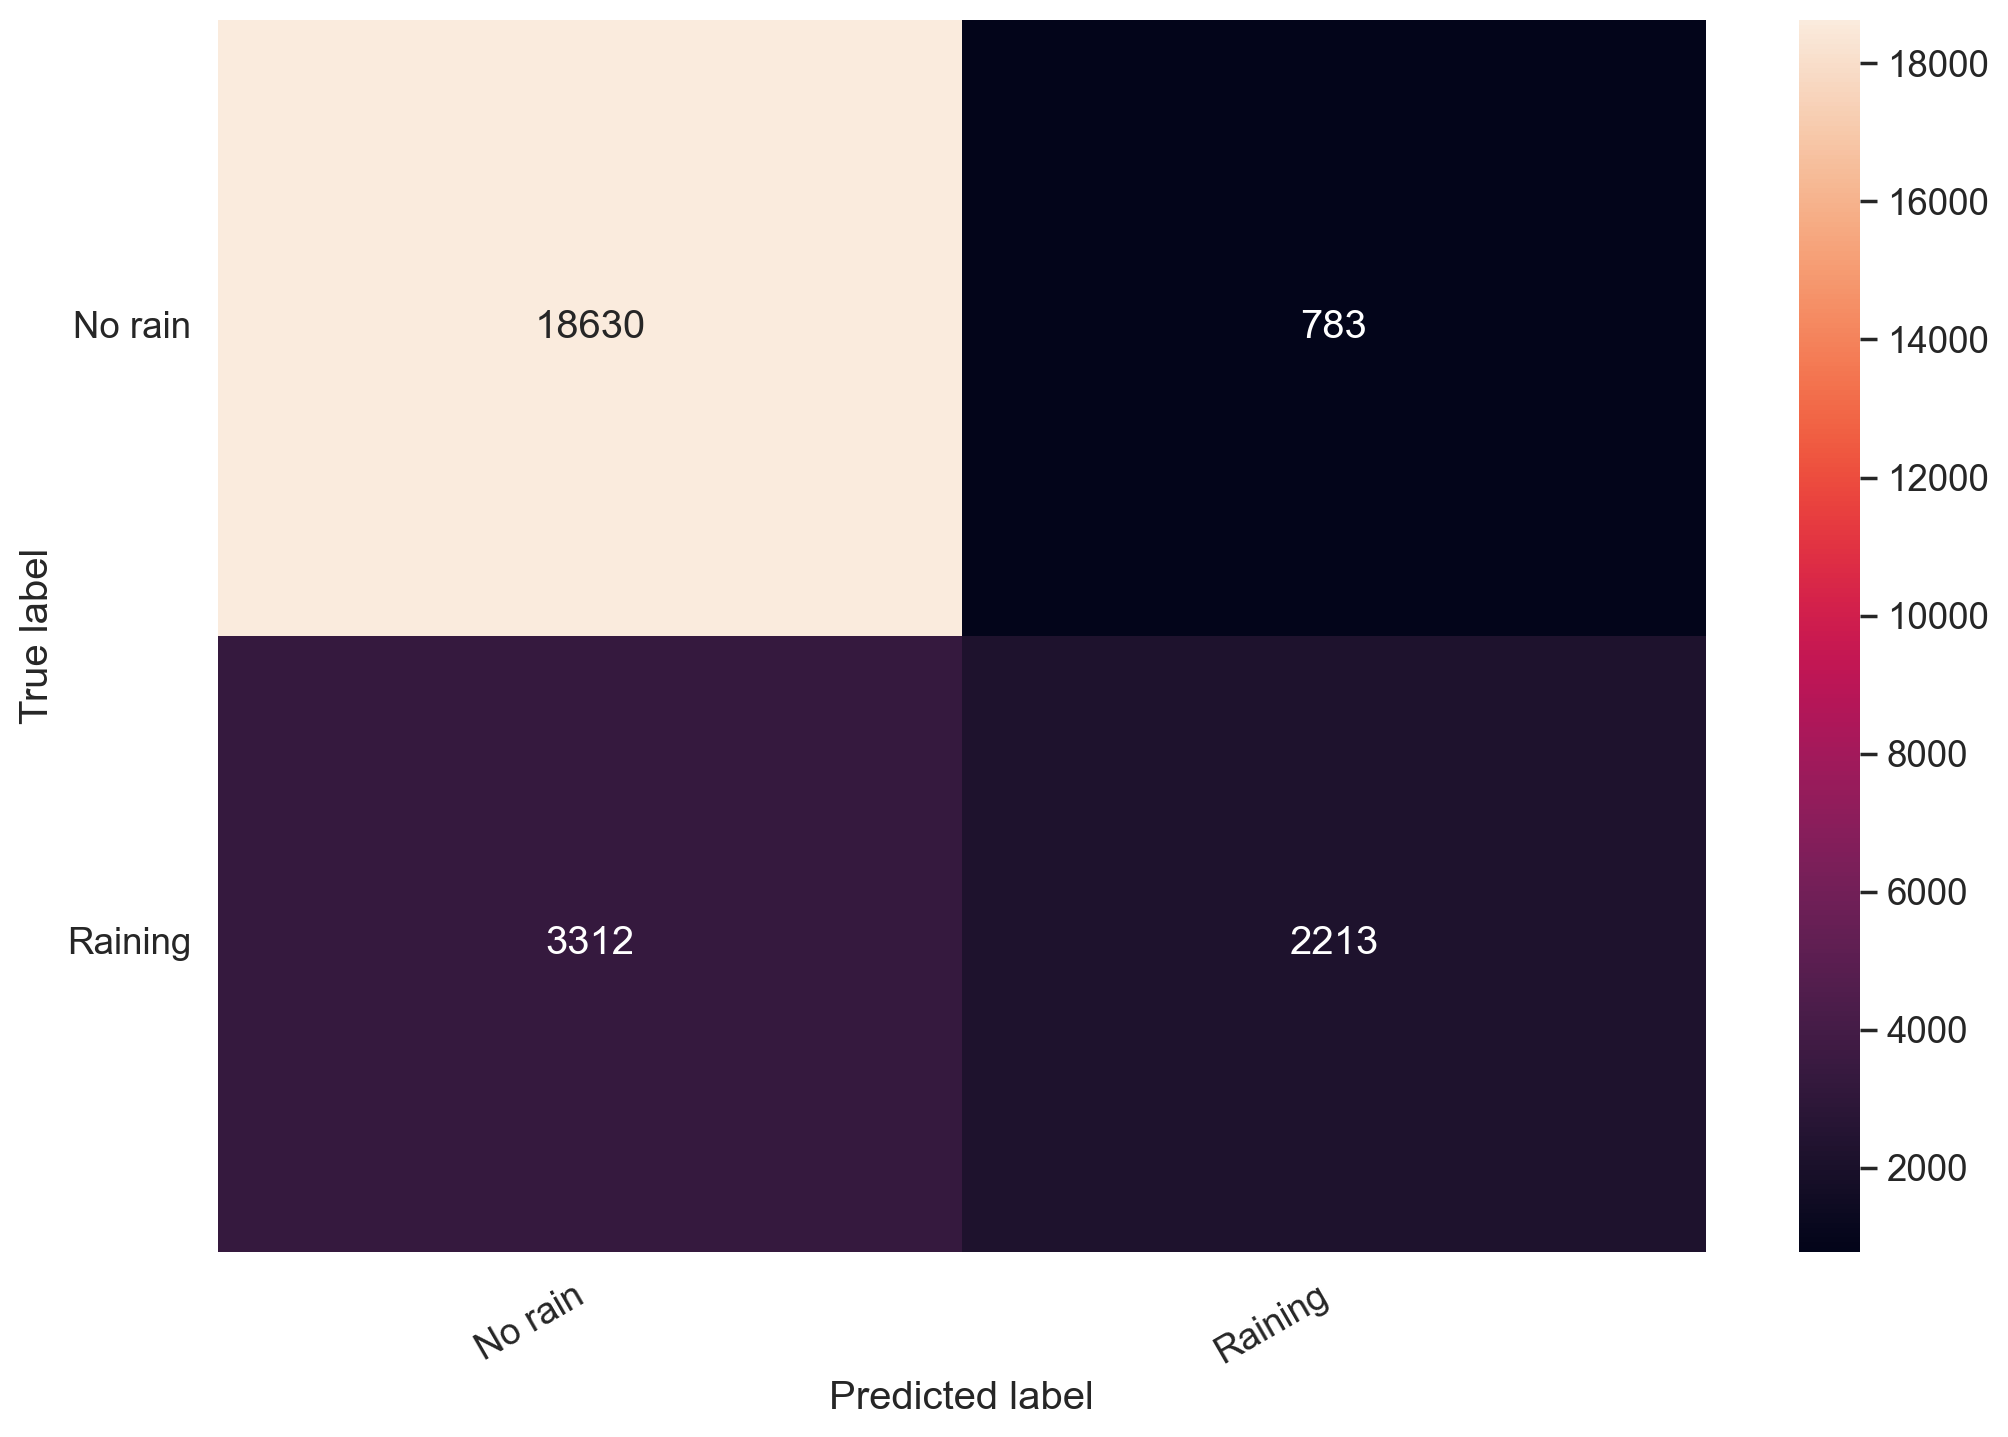

In [221]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [222]:
# 1. Проведите эксперименты, постройте график скорости cходимости сети в зависимости от learning_rate, 
# выберите оптимальное значение.

# 2. Примените нормализацию данных. Исследуйте скорость сходимости.

# 3. Измените струтуру сети. Постройте график/таблицу зависимости качества обучения в зависимости от удаления/добавления
# скрытого слоя, Удаления/добавления нейронов в каждом слое.

# 4. Исследуйте скорость сходимости сети в зависимости от выбранной функции активации в слоях.
# https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

# 5. Исследуйте скорость сходимости сети в зависимости от выбранного метода оптимизации.
# https://pytorch.org/docs/stable/optim.html

# 6. Исследуйте скорость сходимости сети в зависимости от начальной инициализации весов.

In [223]:
# 1. Проведите эксперименты, постройте график скорости cходимости сети в зависимости от learning_rate, 
# выберите оптимальное значение.

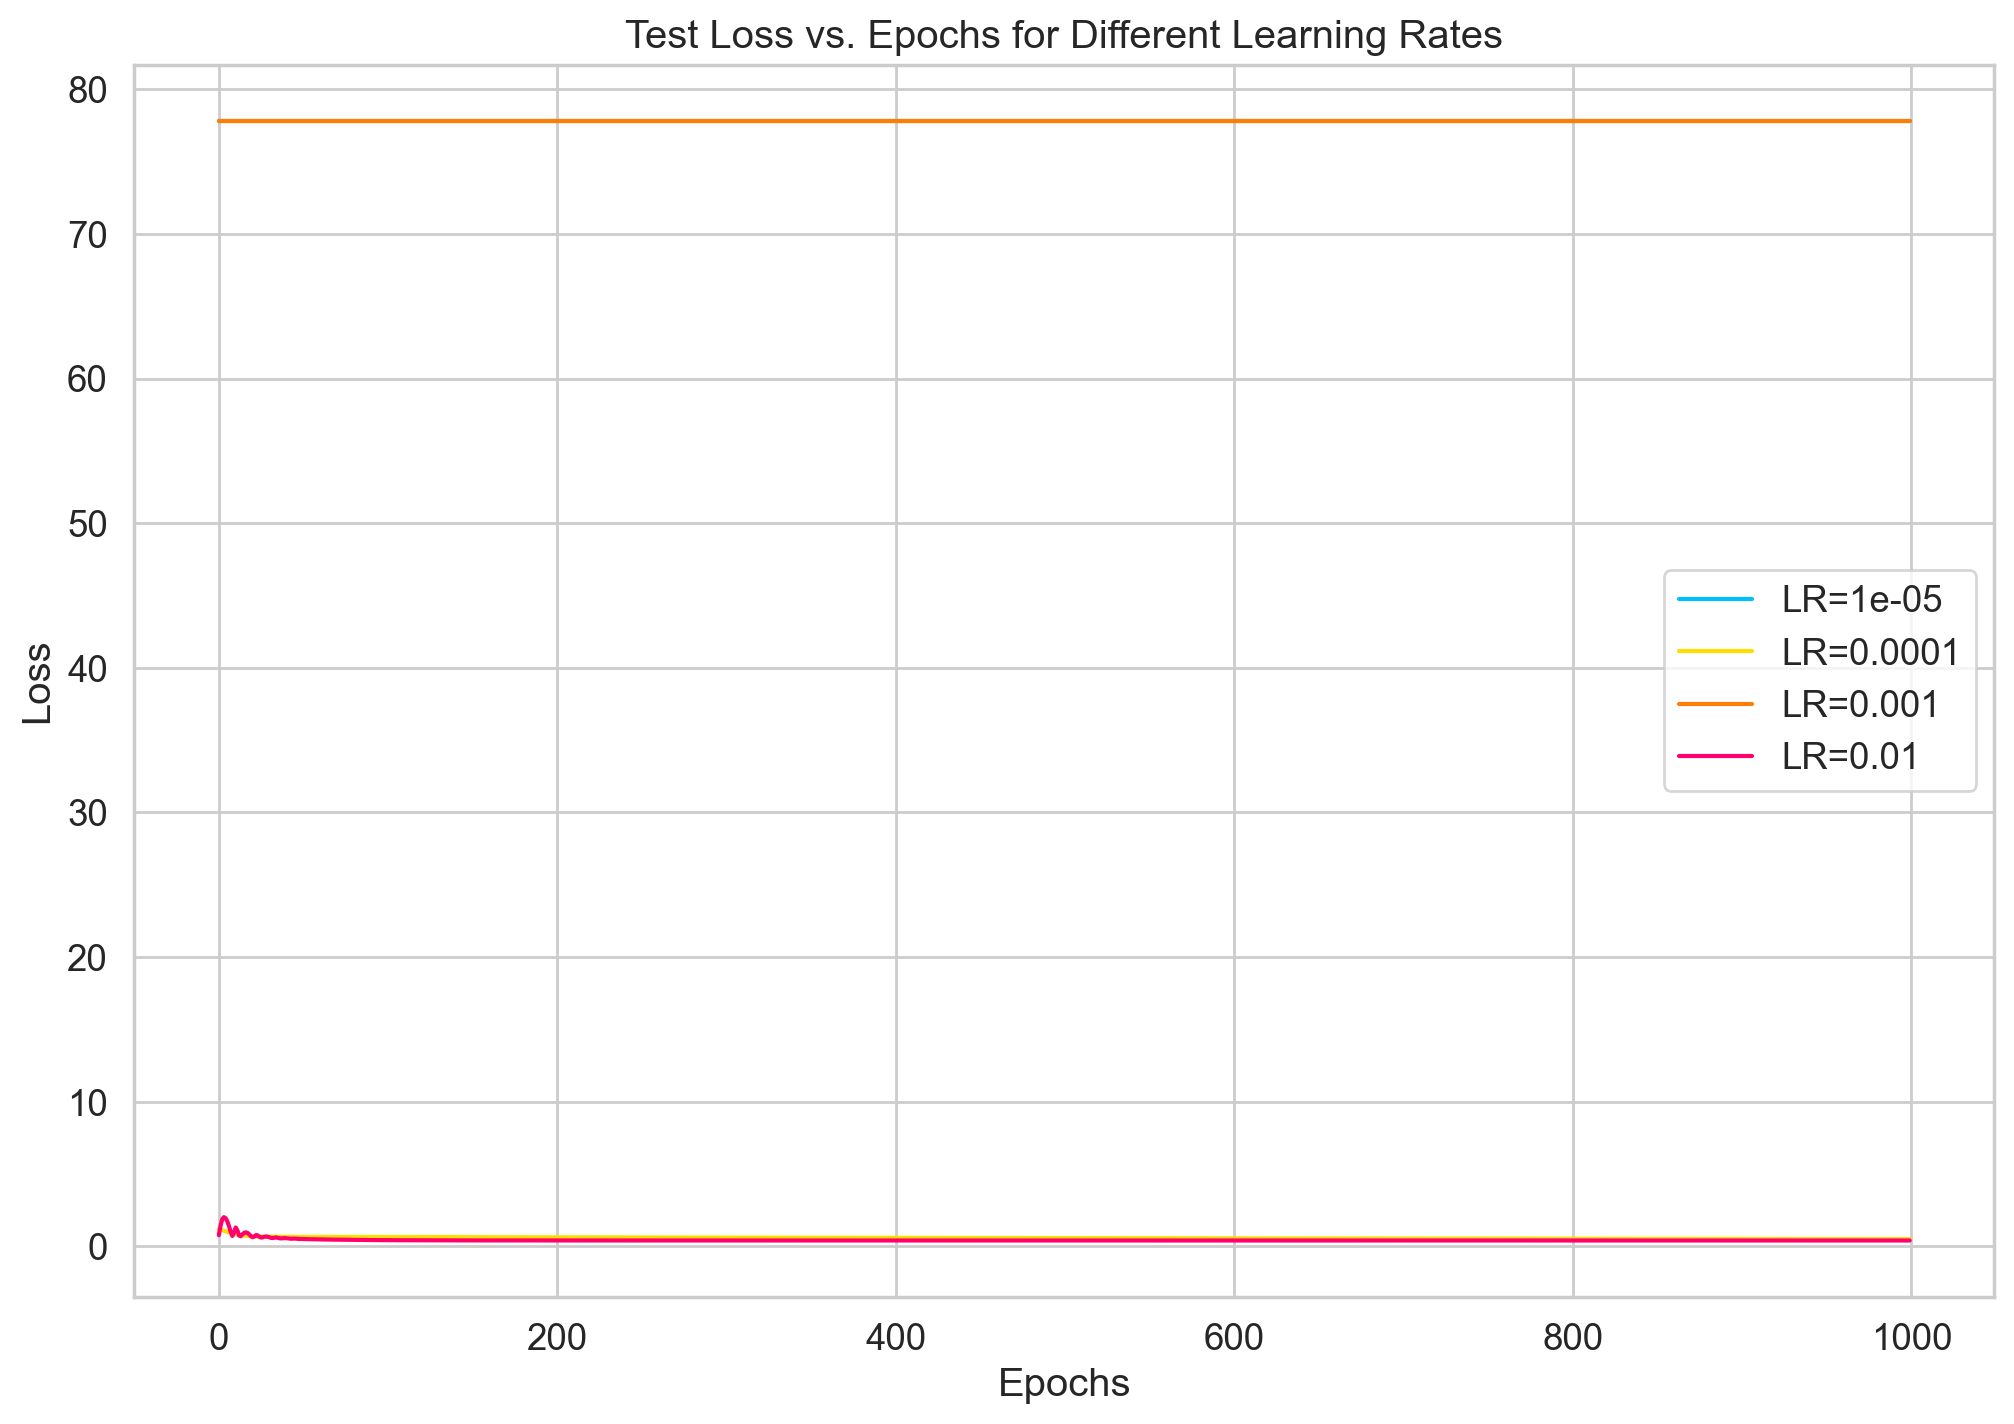

Best learning rate: 0.01


In [224]:
learning_rates = [0.00001, 0.0001, 0.001, 0.01]
num_epochs = 1000
results = {}

device = torch.device("cpu")

for lr in learning_rates:
    net = Net(4).to(device)
    criterion = nn.BCELoss().to(device)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        net.train()
        y_pred = net(X_train)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y_train)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        train_losses.append(train_loss.item())
        net.eval()
        with torch.no_grad():
            y_test_pred = net(X_test)
            y_test_pred = torch.squeeze(y_test_pred)
            test_loss = criterion(y_test_pred, y_test)
            test_losses.append(test_loss.item())

    results[lr] = {'train_losses': train_losses, 'test_losses': test_losses}

plt.figure(figsize=(12, 8))
for lr, data in results.items():
    plt.plot(data['test_losses'], label=f'LR={lr}')

plt.title('Test Loss vs. Epochs for Different Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

final_losses = {lr: data['test_losses'][-1] for lr, data in results.items()}
best_lr = min(final_losses, key=final_losses.get)
print(f"Best learning rate: {best_lr}")


In [225]:
# 2. Примените нормализацию данных. Исследуйте скорость сходимости.

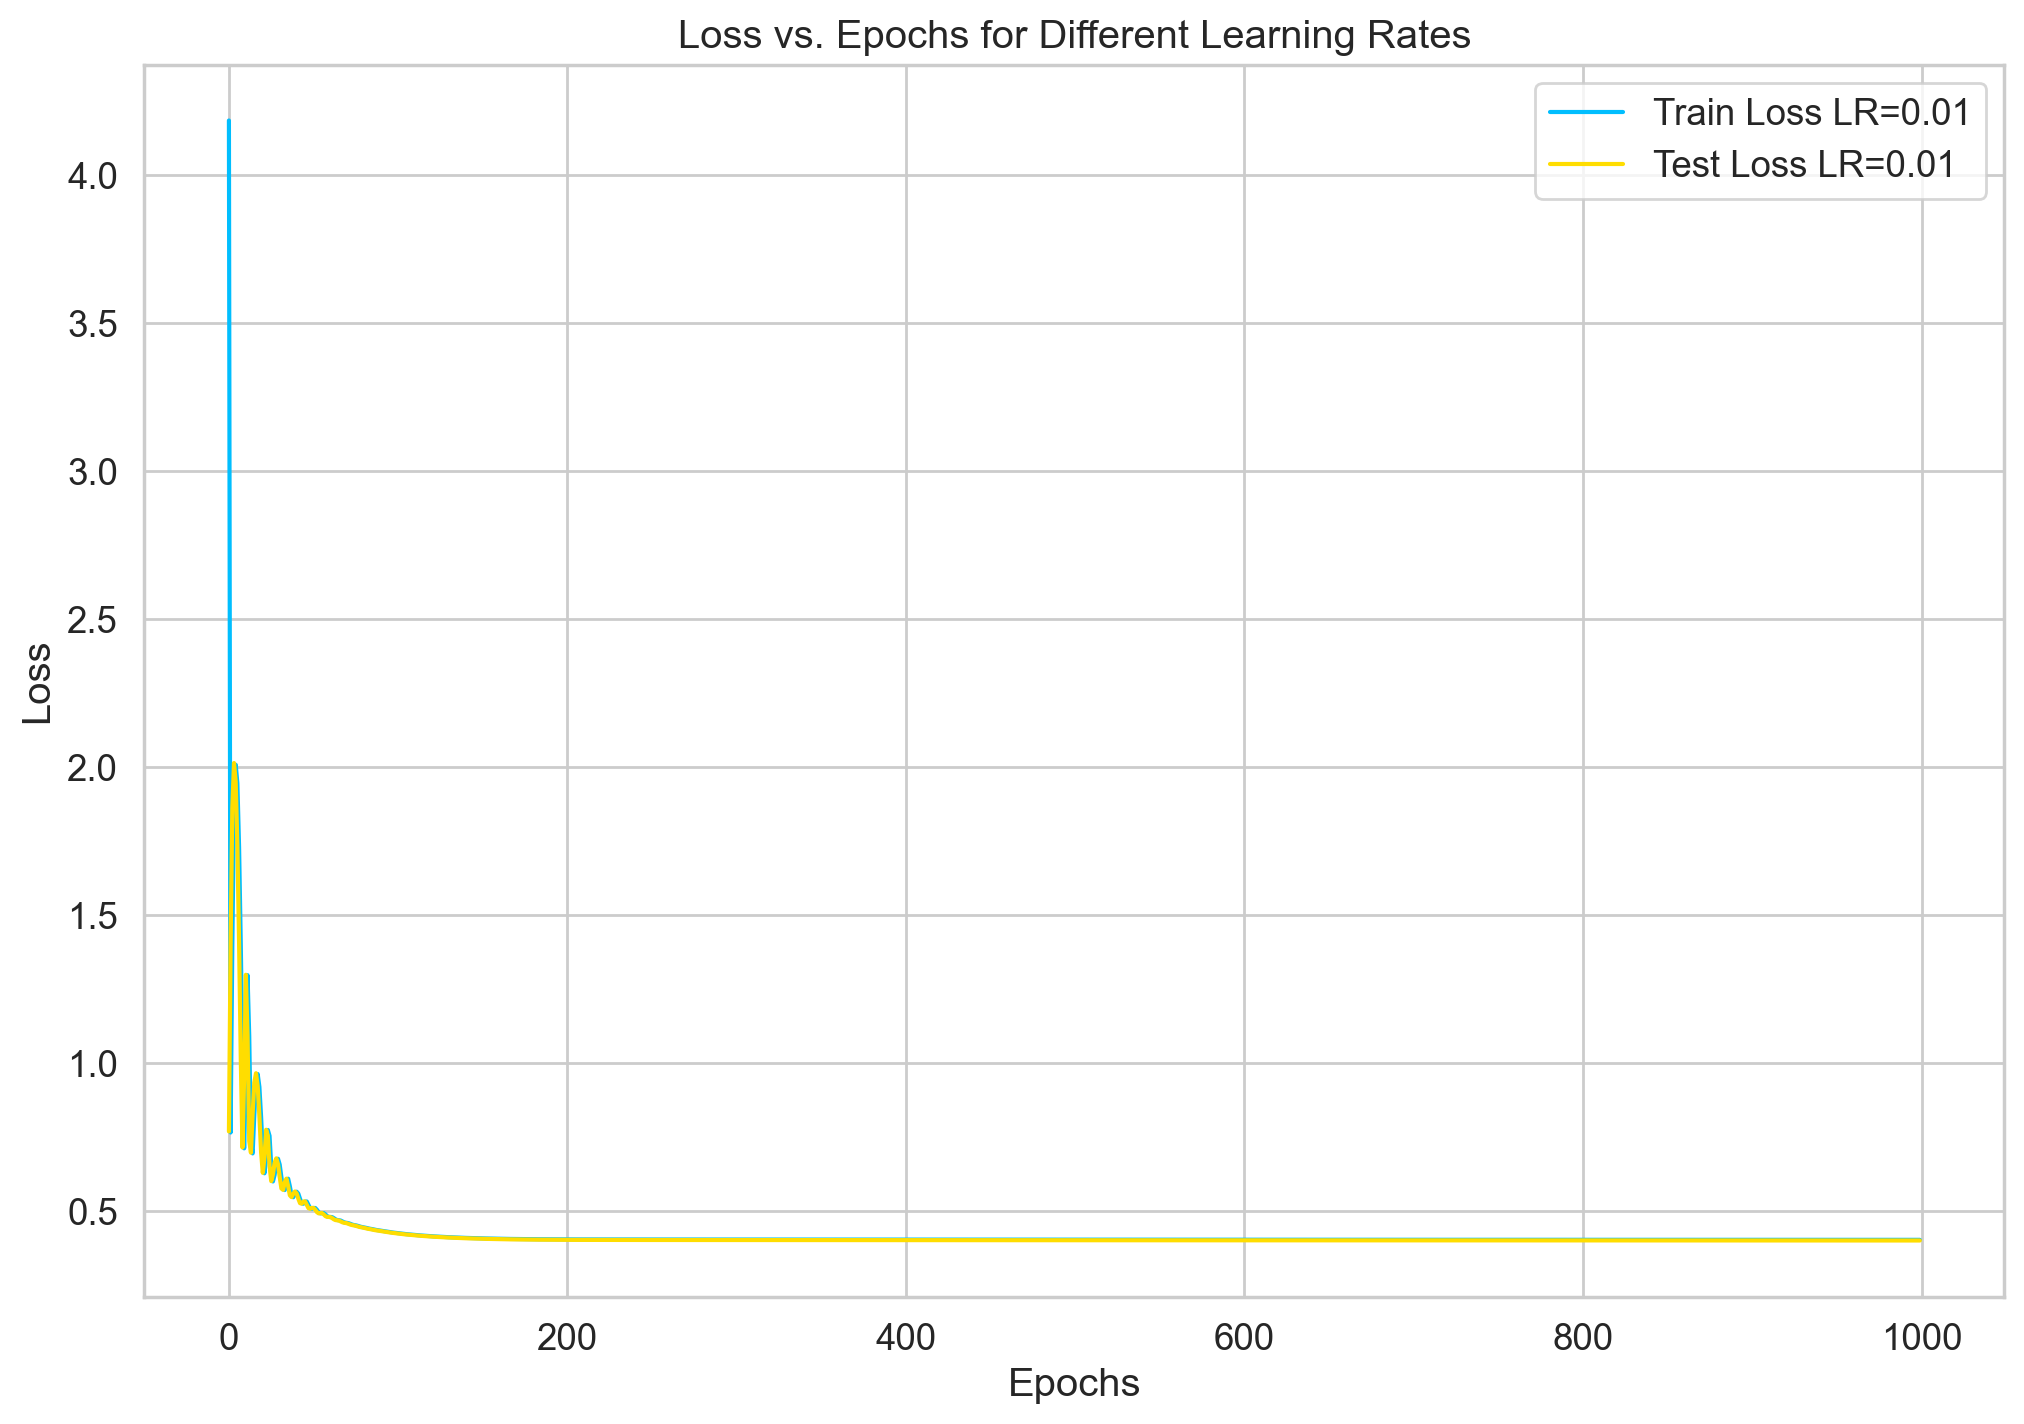

In [226]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_train = torch.from_numpy(X_train).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_test = torch.from_numpy(X_test).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

plt.figure(figsize=(12, 8))
plt.plot(data['train_losses'], label=f'Train Loss LR={0.01}')
plt.plot(data['test_losses'], label=f'Test Loss LR={0.01}')
plt.title('Loss vs. Epochs for Different Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [227]:
# 3. Измените струтуру сети. Постройте график/таблицу зависимости качества обучения в зависимости от удаления/добавления
# скрытого слоя, Удаления/добавления нейронов в каждом слое.

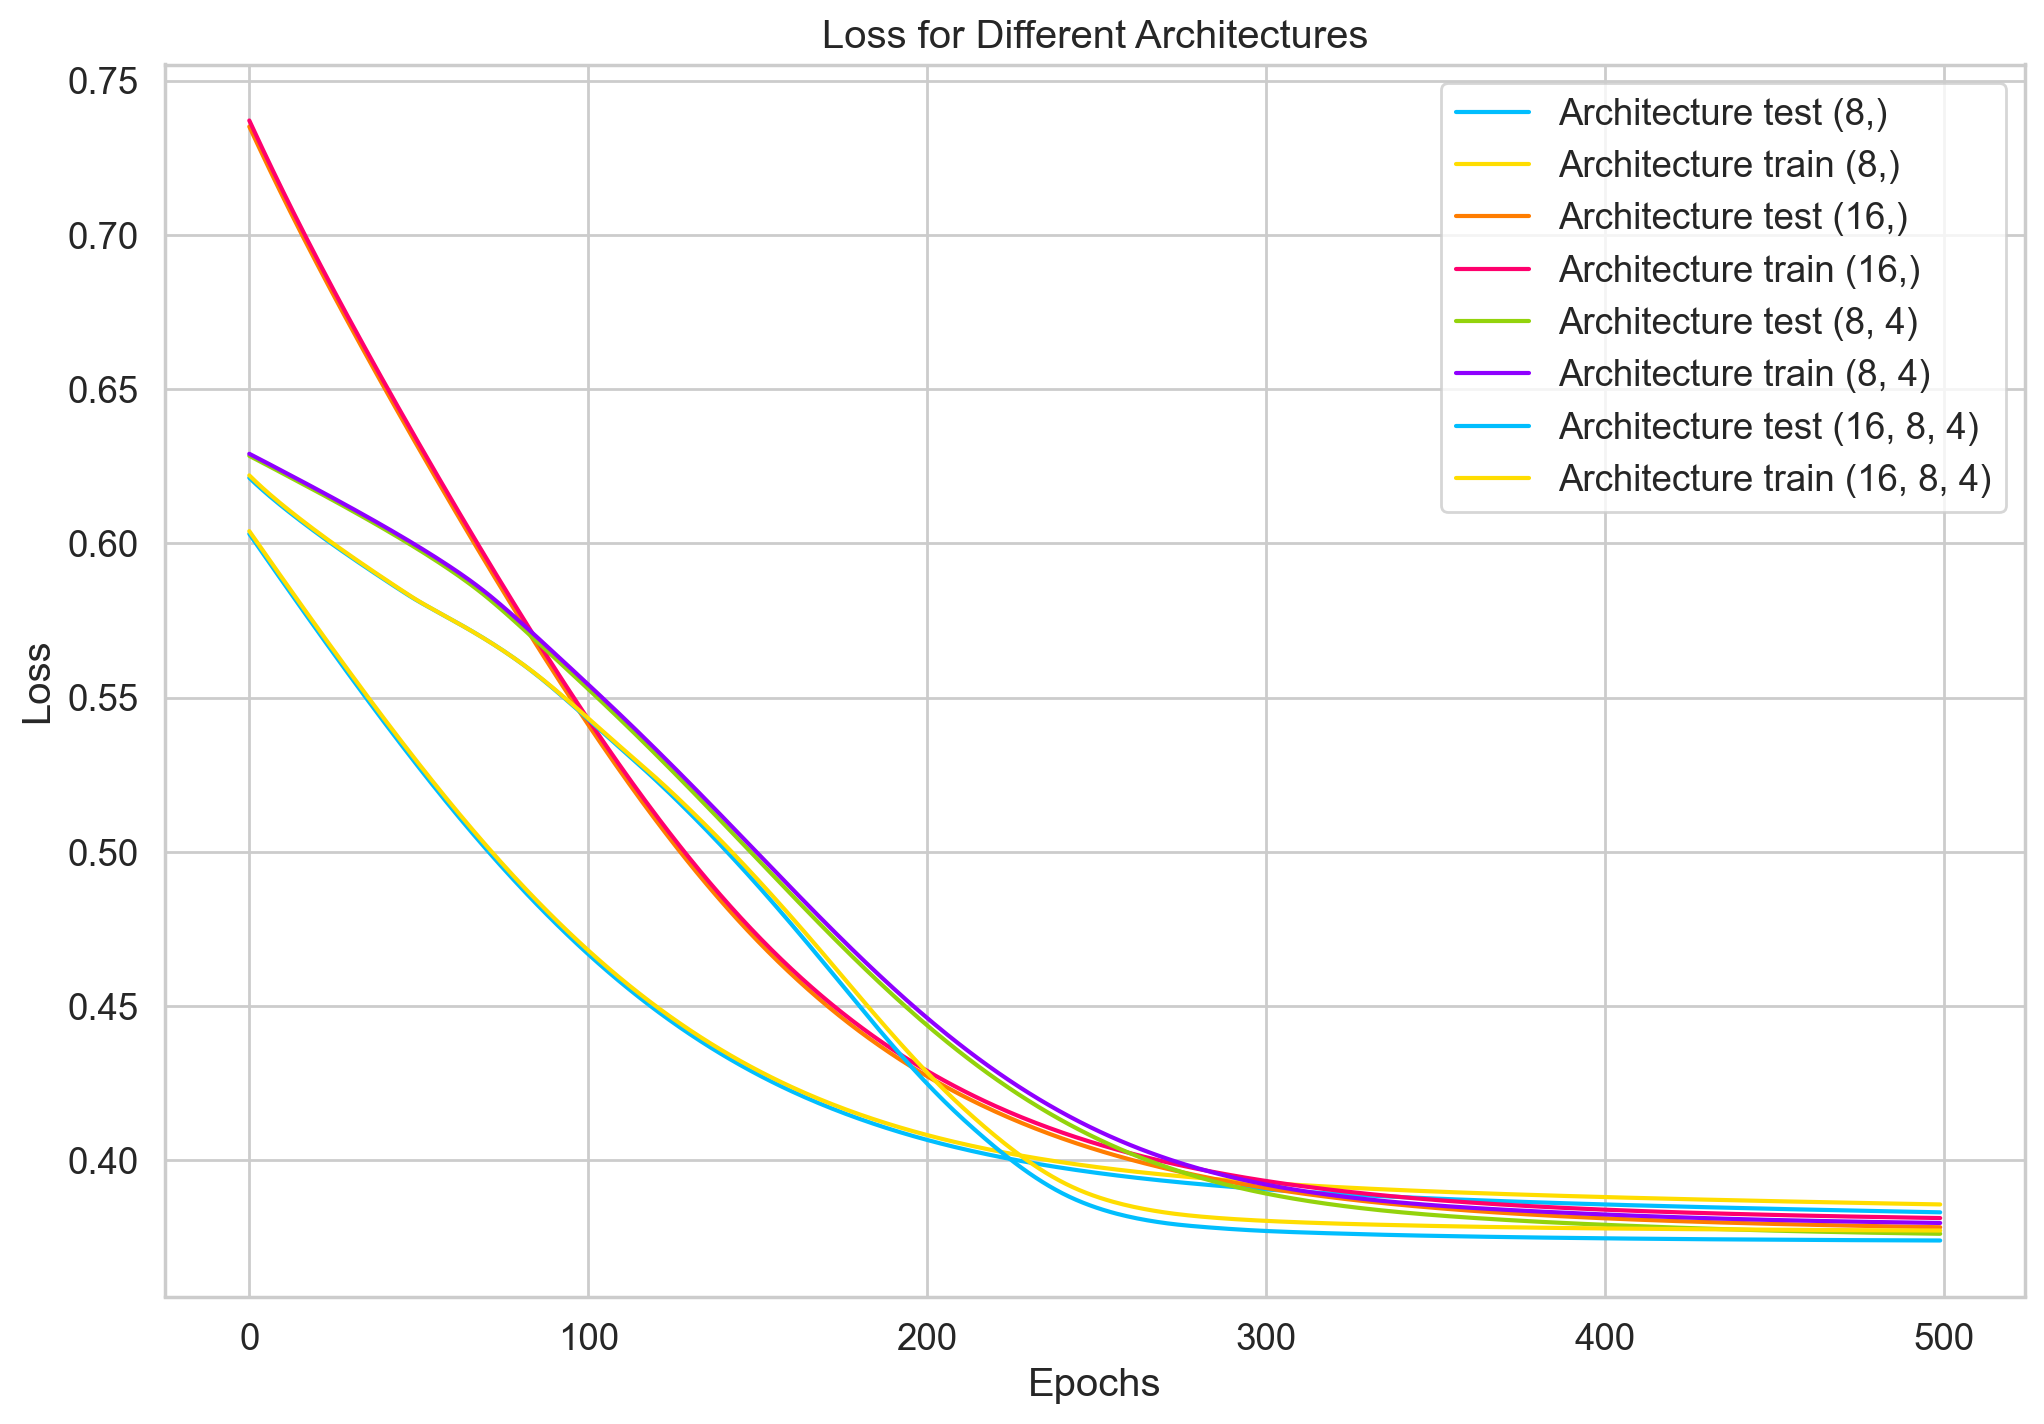

In [228]:
class NetVariant(nn.Module):
    def __init__(self, n_features, hidden_layers):
        """
        n_features: Number of input features
        hidden_layers: List specifying the number of neurons in each hidden layer
        """
        super(NetVariant, self).__init__()
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(n_features, hidden_layers[0]))
        
        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))
        
        self.output = nn.Linear(hidden_layers[-1], 1)

    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
        return torch.sigmoid(self.output(x))

def train_and_evaluate(hidden_layers, learning_rate=0.001, num_epochs=500):
    """
    hidden_layers: List specifying the number of neurons in hidden layers
    learning_rate: Learning rate for the optimizer
    num_epochs: Number of training epochs
    """

    net = NetVariant(n_features=4, hidden_layers=hidden_layers).to(device)
    criterion = nn.BCELoss().to(device)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        net.train()
        y_pred = net(X_train)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y_train)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        train_losses.append(train_loss.item())

        net.eval()
        with torch.no_grad():
            y_test_pred = net(X_test)
            y_test_pred = torch.squeeze(y_test_pred)
            test_loss = criterion(y_test_pred, y_test)
            test_losses.append(test_loss.item())
    
    return train_losses, test_losses

architectures = [
    [8],         
    [16],        
    [8, 4],      
    [16, 8, 4], 
]

results = {}

for arch in architectures:
    train_losses, test_losses = train_and_evaluate(hidden_layers=arch, learning_rate=0.001)
    results[tuple(arch)] = {'train_losses': train_losses, 'test_losses': test_losses}

plt.figure(figsize=(12, 8))
for arch, data in results.items():
    plt.plot(data['test_losses'], label=f'Architecture test {arch}')
    plt.plot(data['train_losses'], label=f'Architecture train {arch}')
plt.title('Loss for Different Architectures')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [229]:
# 4. Исследуйте скорость сходимости сети в зависимости от выбранной функции активации в слоях.
# https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

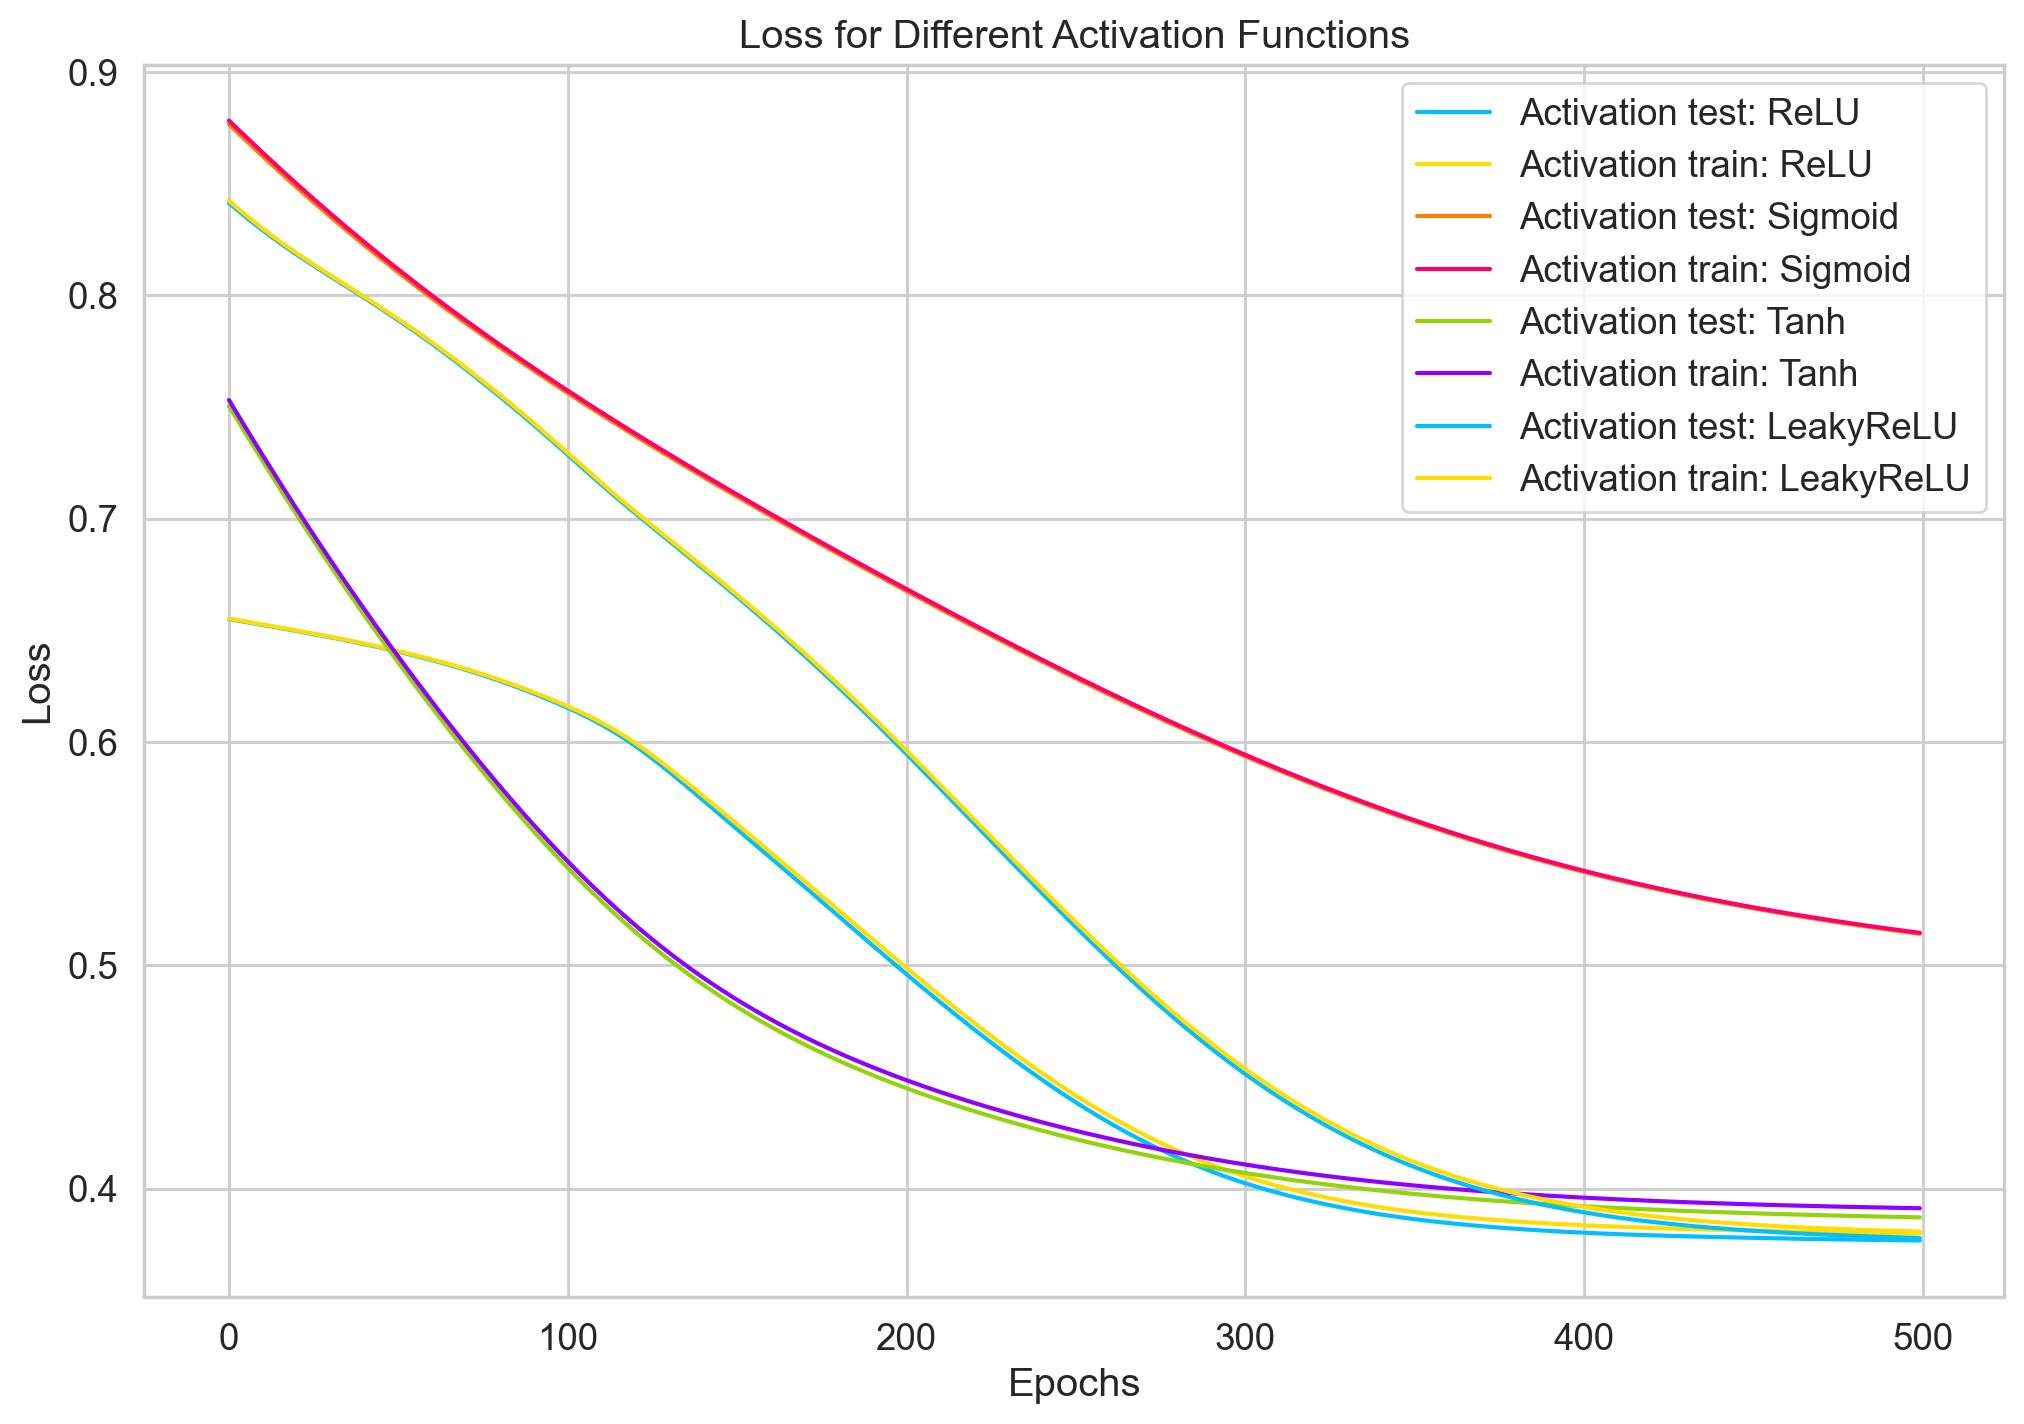

In [230]:
class NetWithActivation(nn.Module):
    def __init__(self, n_features, hidden_layers, activation_fn):
        """
        n_features: количество входных признаков
        hidden_layers: список, задающий количество нейронов в каждом скрытом слое
        activation_fn: функция активации, передается как объект nn.<Activation>
        """
        super(NetWithActivation, self).__init__()
        self.layers = nn.ModuleList()
        self.activation_fn = activation_fn  
        self.layers.append(nn.Linear(n_features, hidden_layers[0]))
        
        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))
        
        self.output = nn.Linear(hidden_layers[-1], 1)

    def forward(self, x):
        for layer in self.layers:
            x = self.activation_fn(layer(x))
        return torch.sigmoid(self.output(x))

def train_and_evaluate_activation(hidden_layers, activation_fn, learning_rate=0.001, num_epochs=500):
    """
    hidden_layers: список с количеством нейронов в скрытых слоях
    activation_fn: функция активации, передается как объект nn.<Activation>
    learning_rate: скорость обучения
    num_epochs: количество эпох обучения
    """
    net = NetWithActivation(n_features=4, hidden_layers=hidden_layers, activation_fn=activation_fn).to(device)
    criterion = nn.BCELoss().to(device)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        net.train()
        y_pred = net(X_train)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y_train)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        train_losses.append(train_loss.item())

        net.eval()
        with torch.no_grad():
            y_test_pred = net(X_test)
            y_test_pred = torch.squeeze(y_test_pred)
            test_loss = criterion(y_test_pred, y_test)
            test_losses.append(test_loss.item())
    
    return train_losses, test_losses

activation_functions = {
    'ReLU': F.relu,
    'Sigmoid': torch.sigmoid,
    'Tanh': torch.tanh,
    'LeakyReLU': F.leaky_relu,
}

hidden_layers = [8, 4]

results = {}

for name, activation_fn in activation_functions.items():
    train_losses, test_losses = train_and_evaluate_activation(
        hidden_layers=hidden_layers, activation_fn=activation_fn, learning_rate=0.001
    )
    results[name] = {'train_losses': train_losses, 'test_losses': test_losses}

plt.figure(figsize=(12, 8))
for name, data in results.items():
    plt.plot(data['test_losses'], label=f'Activation test: {name}')
    plt.plot(data['train_losses'], label=f'Activation train: {name}')
plt.title('Loss for Different Activation Functions')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [231]:
# 5. Исследуйте скорость сходимости сети в зависимости от выбранного метода оптимизации.
# https://pytorch.org/docs/stable/optim.html

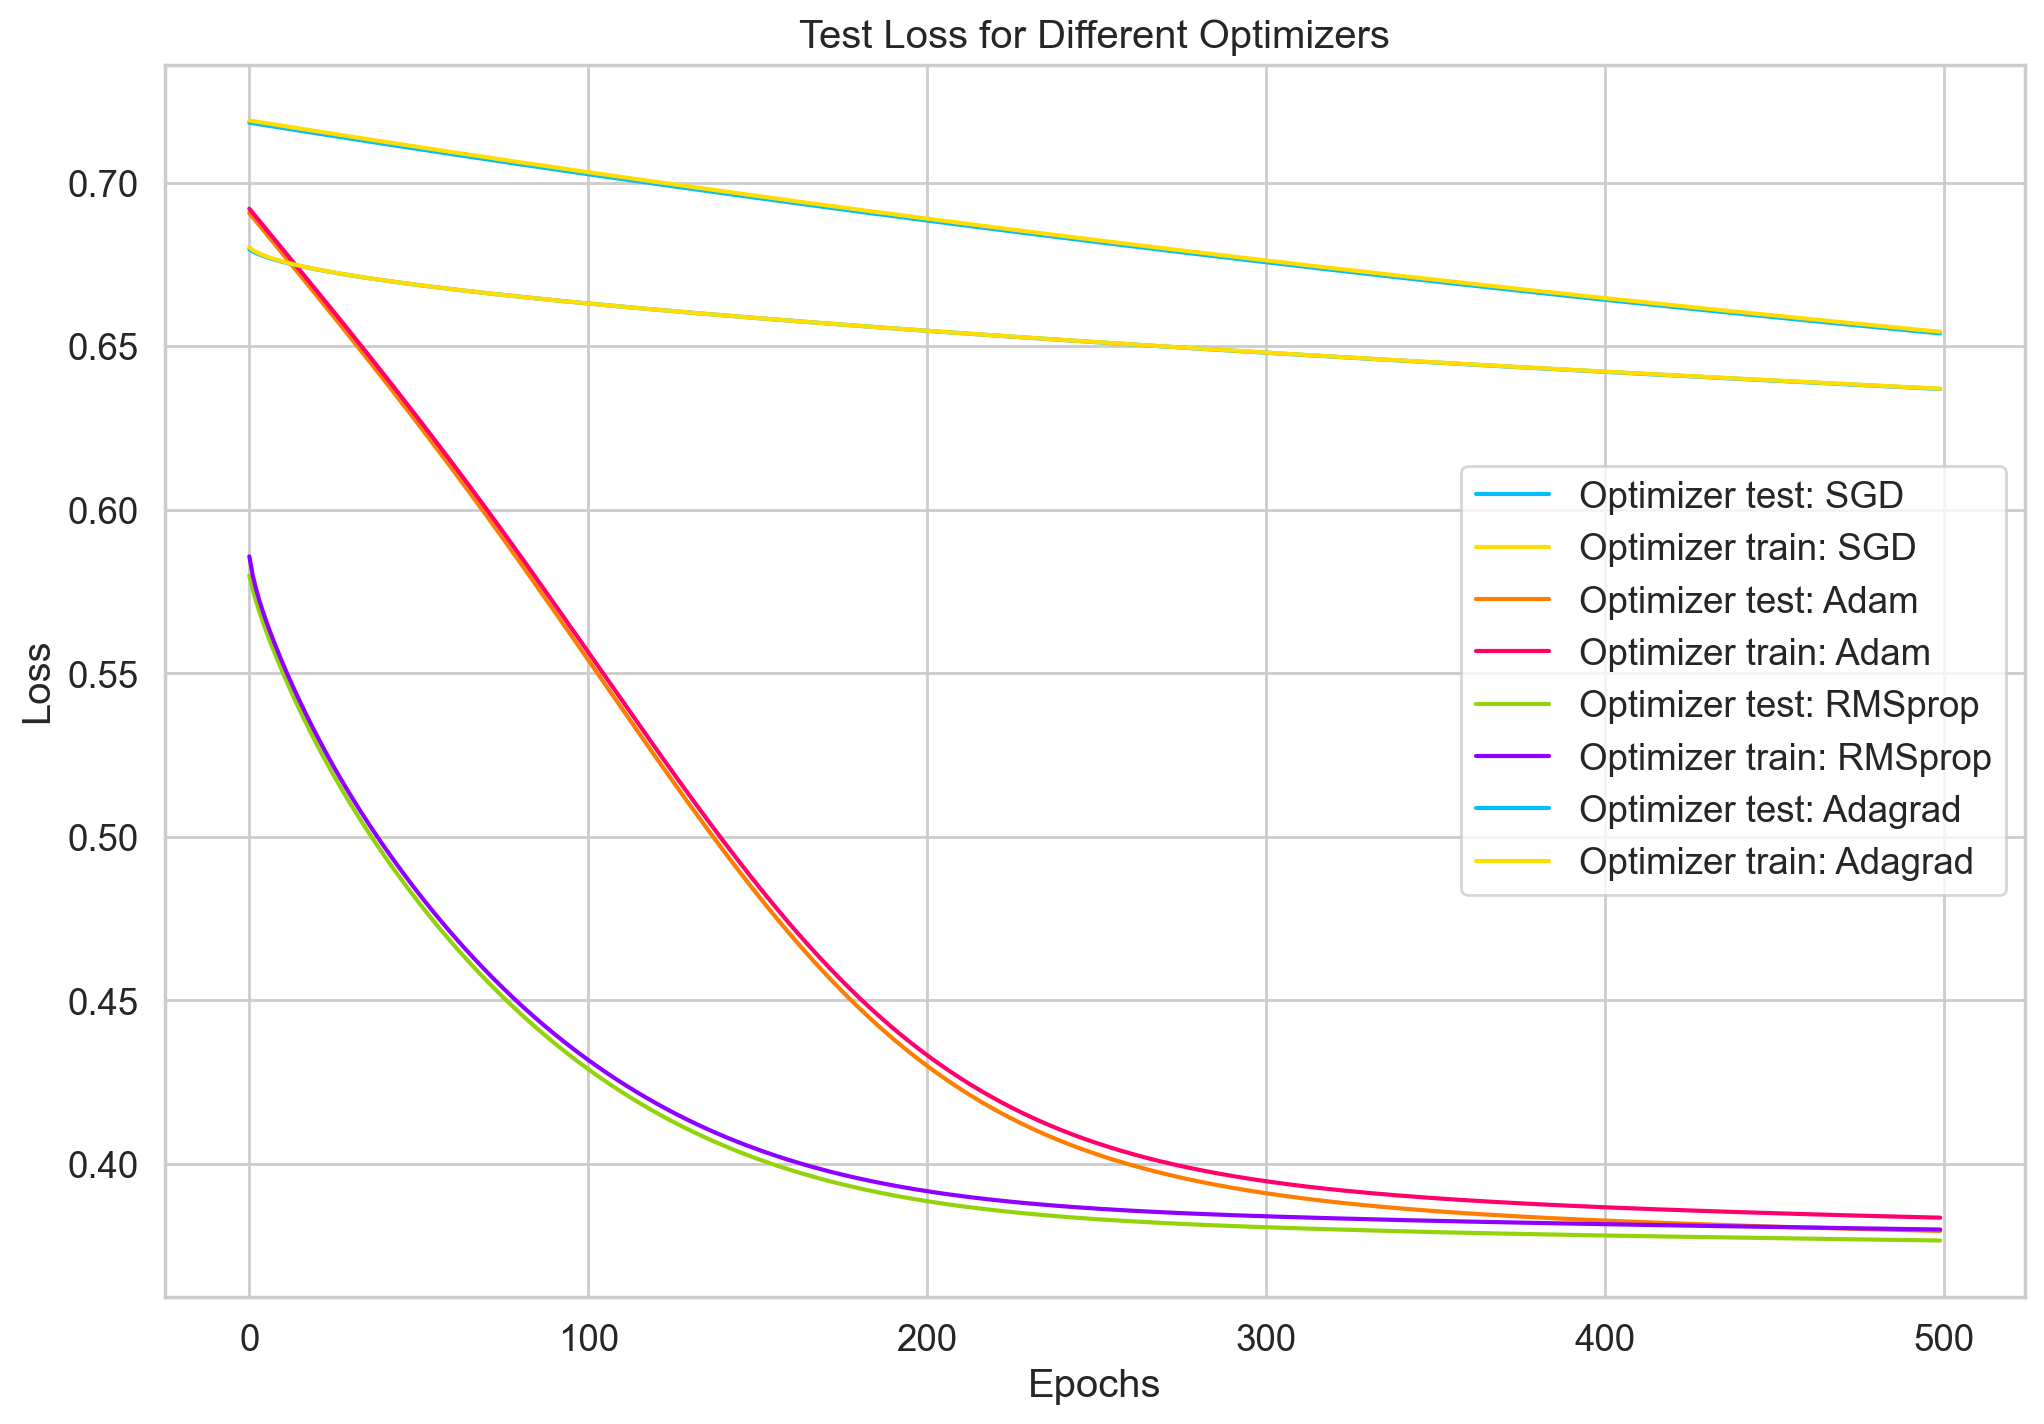

In [232]:
def train_and_evaluate_optimizer(hidden_layers, optimizer_fn, learning_rate=0.001, num_epochs=500):
    """
    hidden_layers: список с количеством нейронов в скрытых слоях
    optimizer_fn: функция, возвращающая оптимизатор, например, optim.SGD
    learning_rate: скорость обучения
    num_epochs: количество эпох обучения
    """
    net = NetWithActivation(n_features=4, hidden_layers=hidden_layers, activation_fn=F.relu).to(device)
    criterion = nn.BCELoss().to(device)
    optimizer = optimizer_fn(net.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        net.train()
        y_pred = net(X_train)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y_train)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())

        net.eval()
        with torch.no_grad():
            y_test_pred = net(X_test)
            y_test_pred = torch.squeeze(y_test_pred)
            test_loss = criterion(y_test_pred, y_test)
            test_losses.append(test_loss.item())
    
    return train_losses, test_losses

optimizers = {
    'SGD': lambda params, lr: optim.SGD(params, lr=lr),
    'Adam': lambda params, lr: optim.Adam(params, lr=lr),
    'RMSprop': lambda params, lr: optim.RMSprop(params, lr=lr),
    'Adagrad': lambda params, lr: optim.Adagrad(params, lr=lr),
}

hidden_layers = [8, 4]

results = {}

for name, optimizer_fn in optimizers.items():
    train_losses, test_losses = train_and_evaluate_optimizer(
        hidden_layers=hidden_layers, optimizer_fn=optimizer_fn, learning_rate=0.001
    )
    results[name] = {'train_losses': train_losses, 'test_losses': test_losses}

plt.figure(figsize=(12, 8))
for name, data in results.items():
    plt.plot(data['test_losses'], label=f'Optimizer test: {name}')
    plt.plot(data['train_losses'], label=f'Optimizer train: {name}')
plt.title('Test Loss for Different Optimizers')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [233]:
# 6. Исследуйте скорость сходимости сети в зависимости от начальной инициализации весов.

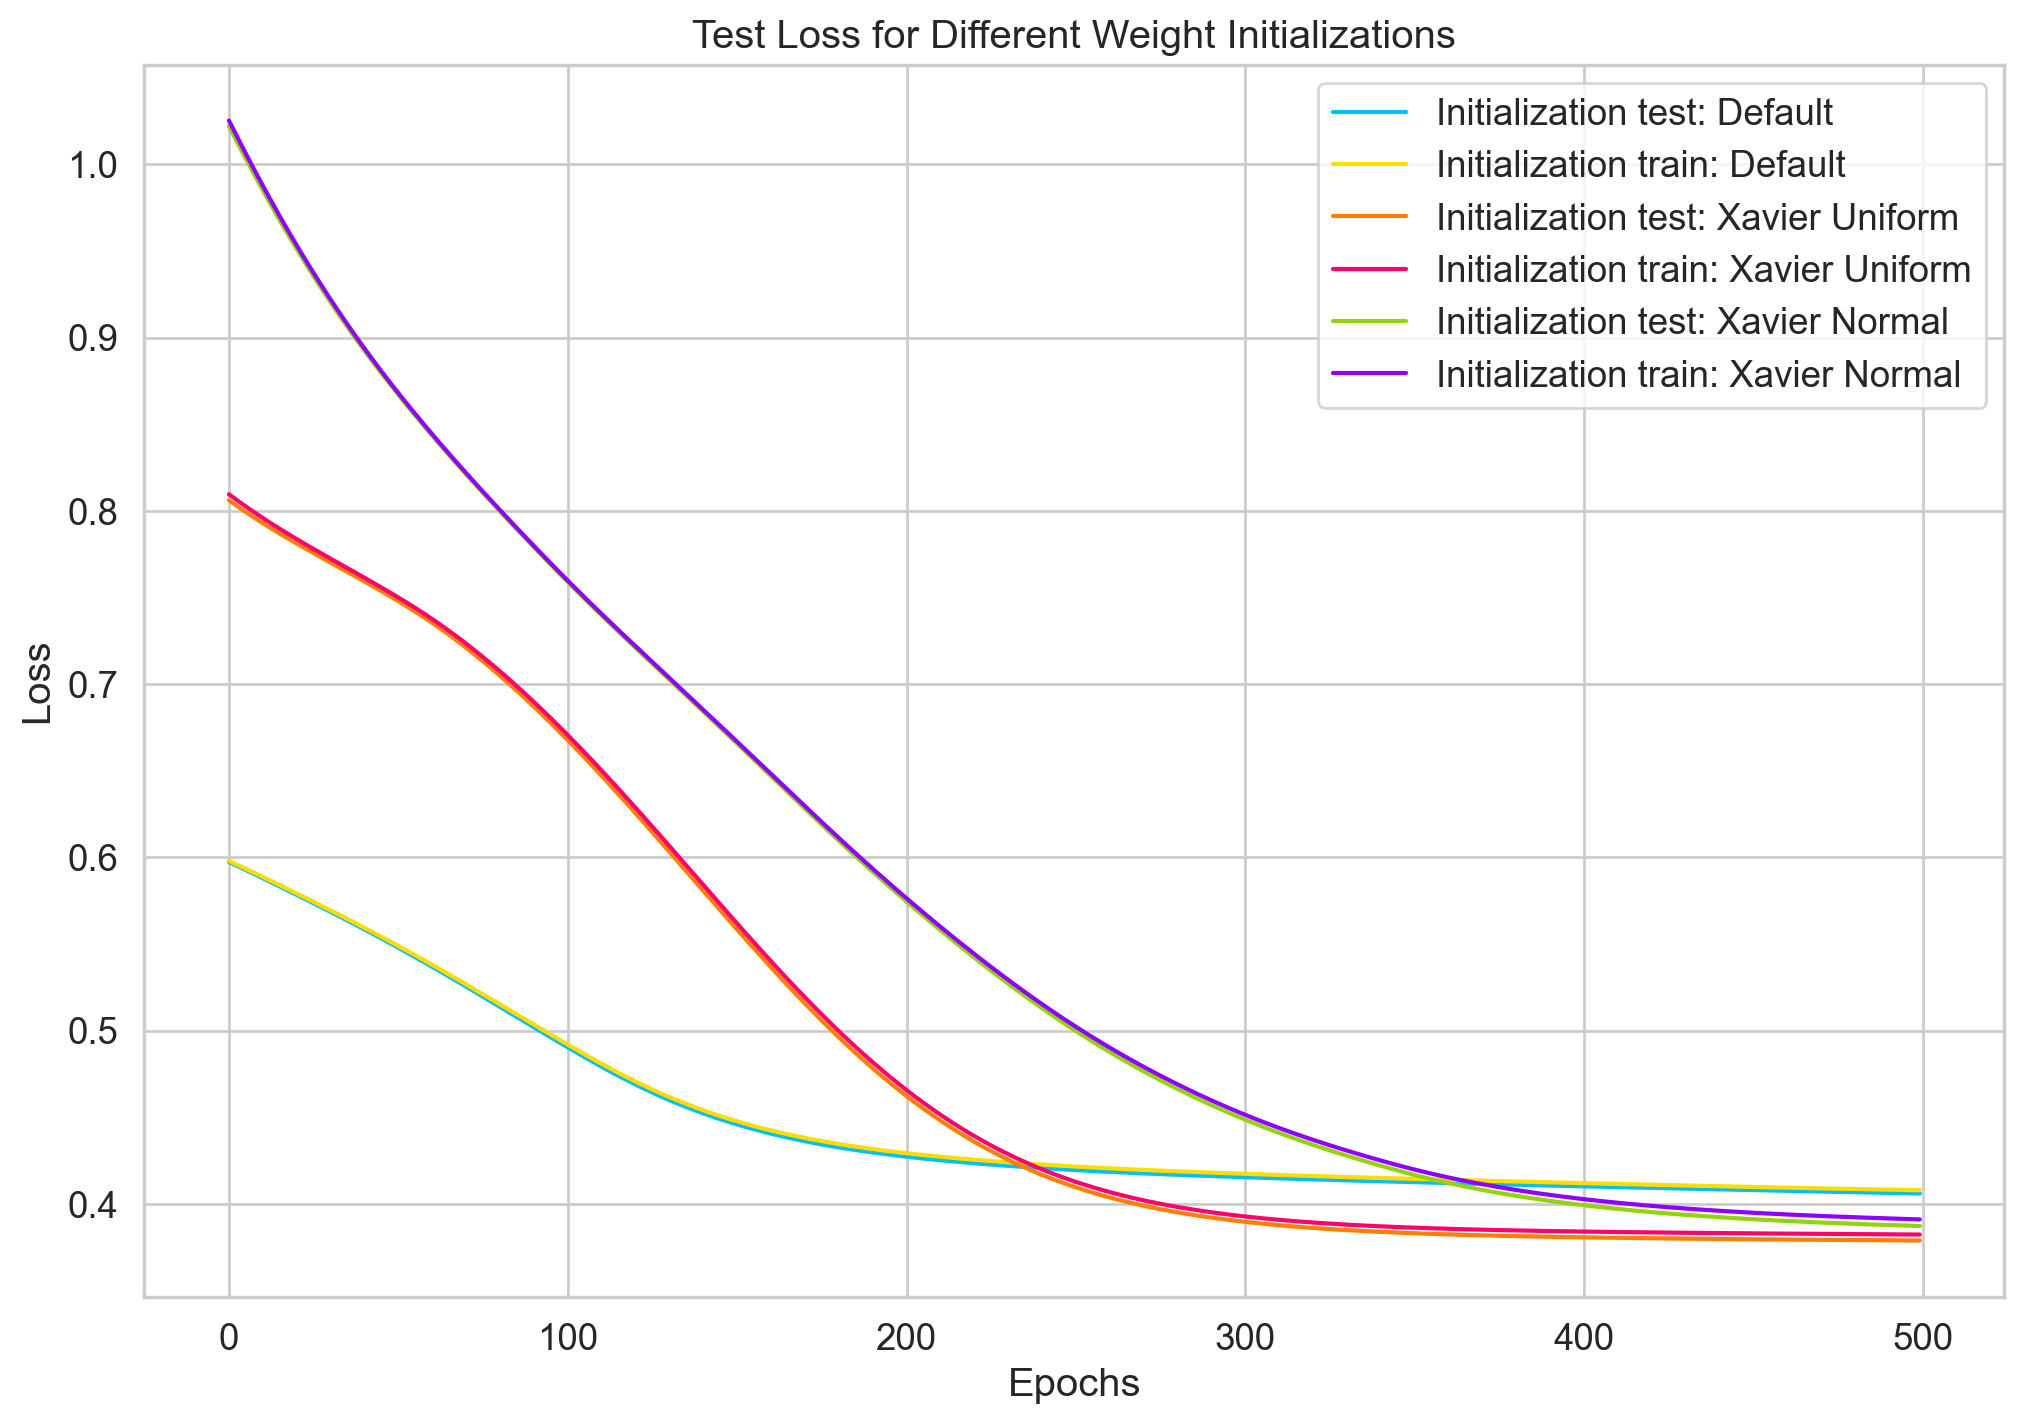

In [235]:
import torch.nn.init as init

class NetWithInitialization(nn.Module):
    def __init__(self, n_features, hidden_layers, activation_fn, init_fn):
        """
        n_features: количество входных признаков
        hidden_layers: список, задающий количество нейронов в каждом скрытом слое
        activation_fn: функция активации
        init_fn: функция инициализации, например, init.xavier_uniform_
        """
        super(NetWithInitialization, self).__init__()
        self.layers = nn.ModuleList()
        self.activation_fn = activation_fn 

        self.layers.append(nn.Linear(n_features, hidden_layers[0]))

        init_fn(self.layers[-1].weight)

        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))
            init_fn(self.layers[-1].weight)

        self.output = nn.Linear(hidden_layers[-1], 1)
        init_fn(self.output.weight)

    def forward(self, x):
        for layer in self.layers:
            x = self.activation_fn(layer(x))
        return torch.sigmoid(self.output(x))

def train_and_evaluate_initialization(hidden_layers, init_fn, activation_fn=F.relu, learning_rate=0.001, num_epochs=500):
    """
    hidden_layers: список с количеством нейронов в скрытых слоях
    init_fn: функция инициализации весов
    activation_fn: функция активации
    learning_rate: скорость обучения
    num_epochs: количество эпох обучения
    """
    net = NetWithInitialization(n_features=4, hidden_layers=hidden_layers, activation_fn=activation_fn, init_fn=init_fn).to(device)
    criterion = nn.BCELoss().to(device)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        net.train()
        y_pred = net(X_train)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())

        net.eval()
        with torch.no_grad():
            y_test_pred = net(X_test)
            y_test_pred = torch.squeeze(y_test_pred)
            test_loss = criterion(y_test_pred, y_test)
            test_losses.append(test_loss.item())

    return train_losses, test_losses

initializations = {
    'Default': lambda w: None, 
    'Xavier Uniform': init.xavier_uniform_,
    'Xavier Normal': init.xavier_normal_,
}

hidden_layers = [8, 4]

results = {}

for name, init_fn in initializations.items():
    train_losses, test_losses = train_and_evaluate_initialization(
        hidden_layers=hidden_layers, init_fn=init_fn, learning_rate=0.001
    )
    results[name] = {'train_losses': train_losses, 'test_losses': test_losses}

plt.figure(figsize=(12, 8))
for name, data in results.items():
    plt.plot(data['test_losses'], label=f'Initialization test: {name}')
    plt.plot(data['train_losses'], label=f'Initialization train: {name}')
plt.title('Test Loss for Different Weight Initializations')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
